# Regresión

El [NO2 dataset](https://www.openml.org/d/547) contiene 500 mediciones de la contaminación causada por los coches. El objetivo es predecir la concentración de $NO_2$ a partir de datos sobre el tráfico y las condiciones atmosféricas. Las variables de predicción incluyen el número de coches por hora, la temperatura, el viento y la hora del día.

In [1]:

# General imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openml as oml
from matplotlib import cm

# Hide convergence warning for now
import warnings
from sklearn.exceptions import ConvergenceWarning
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
# Download NO2 data. Takes a while the first time.
no2 = oml.datasets.get_dataset(547)
X, y, _, _ = no2.get_data(target=no2.default_target_attribute); 
attribute_names = list(X)

## Visualización rápida
Podemos utilizar pandas para visualizar rápidamente los datos. 

Eliminaremos la función 'día' para centrarnos en los aspectos no temporales de esta interacción. No pretendemos predecir los niveles futuros, e incluso si lo hiciéramos requeriría un tratamiento especial (por ejemplo, diferentes divisiones entrenamiento-prueba). Tampoco parece haber una tendencia a largo plazo en los datos, aunque sí hay tendencias periódicas claras en la temperatura.

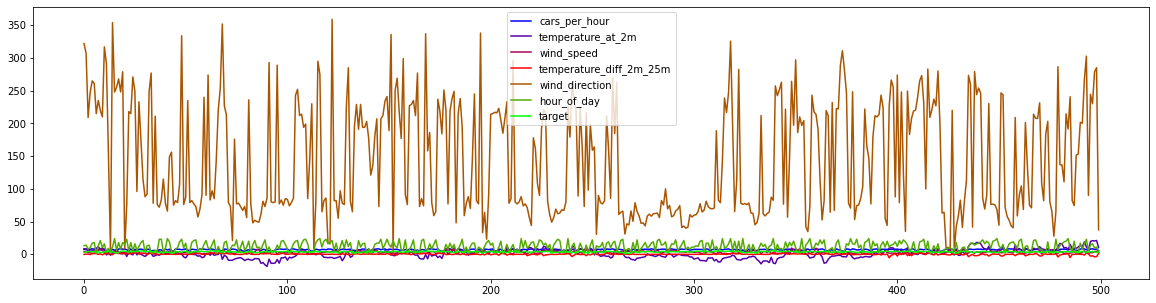

In [3]:
df = pd.DataFrame(X, columns=attribute_names).join(pd.DataFrame(list(y),columns=['target']))
df = df.sort_values(['day','hour_of_day']).drop('day',axis=1)
df.plot(use_index=False,figsize=(20,5),cmap=cm.get_cmap('brg'));
X = X.drop('day',axis=1)

In [4]:
df.head()

,cars_per_hour,temperature_at_2m,wind_speed,temperature_diff_2m_25m,wind_direction,hour_of_day,target
42,7.64300,8.5,4.3,-0.2,322.0,13,3.22287
20,7.75061,8.2,4.5,0.2,307.0,14,3.15274
255,8.12415,5.2,2.8,0.3,209.0,8,4.19570
488,7.64108,6.7,2.3,-0.4,247.0,10,3.98155
94,8.31630,6.3,1.2,1.3,265.0,17,4.14155


Si trazamos los datos, ordenados por hora de medición, podemos ver que la dirección del viento (medida en grados angulares) se escala de forma muy diferente a las demás características. Acerquémonos ahora a las demás medidas:

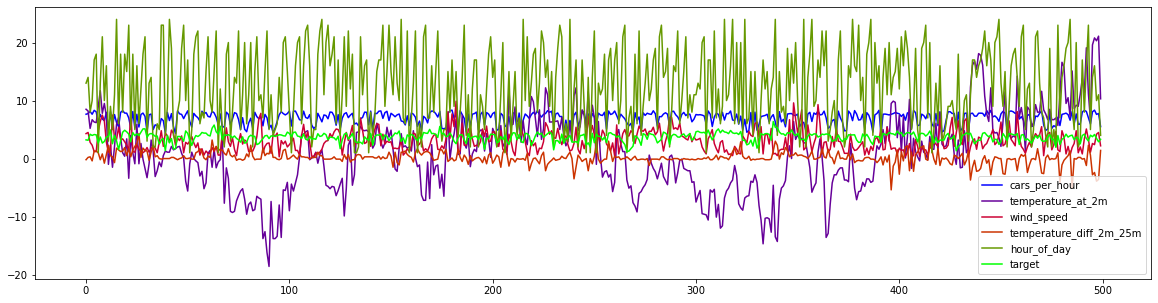

In [5]:
df.drop('wind_direction',axis=1).plot(use_index=False,figsize=(20,5),cmap=cm.get_cmap('brg'));

Podemos ver que el objetivo (niveles de $NO_2$) parece estar correlacionado con el número de coches por hora, lo que tiene sentido porque los coches producen $NO_2$. Otras influencias (diferencias de temperatura del aire y viento) parecen tener un efecto más complejo y sutil. Intentemos modelizarlas utilizando modelos de regresión lineal.

## Ejercicio 1: Modelo de referencia
Está claro que las concentraciones de $NO_2$ dependen de una combinación de estas características, por lo que ahora intentaremos aprender esta compleja relación. Primero evaluamos una serie de problemas de regresión lineal, es decir, regresión lineal, Ridge, Lasso y ElasticNet, así como kNN. Dado que observamos que algunas características tienen escalas muy diferentes, también construiremos pipelines de todas estas medidas con un paso adicional de escalado. Por ahora, nos ceñiremos a la configuración predeterminada de los hiperparámetros.

### Ejercicio 1.1
Implemente la siguiente función que evalúa cada clasificador que se le pasa en los datos dados, y luego devuelve las puntuaciones de entrenamiento y prueba de cada uno como una lista. 

Puedes importar funciones adicionales de cualquier módulo que desees, pero deberías ser capaz de completar la función con la función [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) y los componentes estándar de Python. Debajo de la función encontrarás un ejemplo de salida.

In [6]:
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
import numpy as np

In [7]:

def evaluate_learners(models, X, y):
    """     
    Given a list of models [model1, model2, ..., modelN] return two lists:
     - a list with the scores obtained on the training samples for each model,
     - a list with the test scores obtained on the test samples for each model.
     The order of scores should match the order in which the models were originally provided. E.g.:     
     [Model1 train score, ..., ModelN train score], [Model1 test score, ..., ModelN test score]
    """
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    xvals = [cross_validate(reg, X, y, return_train_score= True, cv=cv, scoring='neg_mean_squared_error') for reg in models]
    train_scores = [np.sqrt(x['train_score']*-1) for x in xvals]
    test_scores = [np.sqrt(x['test_score']*-1) for x in xvals]
    return train_scores, test_scores

# valores de mean_squared_error con KNeighborsRegressor():
# ([array([-0.31986051, -0.30547347, -0.30662164, -0.323207  , -0.32930237])], [array([-0.3983512 , -0.62692981, -0.55888416, -0.47697598, -0.42956013])])
#################################
# valores de la raiz cuadrada de mean_squared_error con KNeighborsRegressor():
# ([array([0.56556212, 0.55269655, 0.55373427, 0.56851297, 0.57384873])], [array([0.63115069, 0.79178899, 0.74758555, 0.69063447, 0.65540837])])
#################################


In [8]:
# Probando la funcion con un solo regresor
regresor = [KNeighborsRegressor()]
X=df.iloc[:,:-1]
y=df['target']
print(evaluate_learners(regresor,X,y))


([array([0.56556212, 0.55269655, 0.55373427, 0.56851297, 0.57384873])], [array([0.63115069, 0.79178899, 0.74758555, 0.69063447, 0.65540837])])


### Ejercicio 1.2
Llame a la función que ha creado con una regresión lineal, Ridge, Lasso y ElasticNet, y tambien kNN.

Guarde los valores de retorno en las variables `train_scores` y `test_scores`.

A continuación, ejecute el código que se indica a continuación para producir un gráfico que visualice las puntuaciones.

In [9]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor

# Se obtiene el score para los modelos lineal, Ridge, Lasso, ElasticNet y KNN
regresor = [LinearRegression(),Lasso(),Ridge(),ElasticNet(),KNeighborsRegressor()]
X=df.iloc[:,:-1]
y=df['target']
train_scores, test_scores = evaluate_learners(regresor,X,y)
print('Train scores:')
print(train_scores)
print('Test scores:')
print(test_scores)

Train scores:
[array([0.5357296 , 0.50377867, 0.52345296, 0.52900528, 0.53280478]), array([0.74454841, 0.72663802, 0.73928798, 0.73027346, 0.74097631]), array([0.53573233, 0.50378179, 0.52345552, 0.5290078 , 0.53280733]), array([0.71679944, 0.70404516, 0.71194427, 0.70411118, 0.71464549]), array([0.56556212, 0.55269655, 0.55373427, 0.56851297, 0.57384873])]
Test scores:
[array([0.49434493, 0.61560559, 0.53890562, 0.52060891, 0.50229   ]), array([0.67763303, 0.79844996, 0.72758867, 0.7515087 , 0.74470069]), array([0.49419544, 0.61532114, 0.53895404, 0.52077233, 0.50235634]), array([0.66810393, 0.76157086, 0.70372625, 0.73416601, 0.707703  ]), array([0.63115069, 0.79178899, 0.74758555, 0.69063447, 0.65540837])]


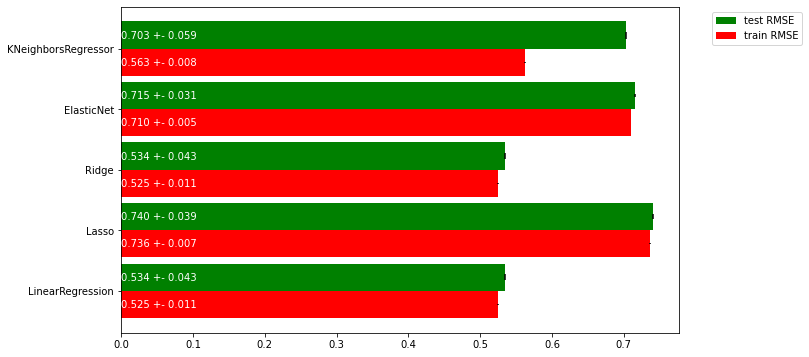

In [10]:
# Plot a bar chart of the train and test scores of all the classifiers, including the variance as error bars
fig, ax = plt.subplots(figsize=(10,6))
width=0.45

ax.barh(np.arange(len(train_scores)), np.mean(test_scores, axis=1), width,
        yerr= np.std(test_scores, axis=1), color='green', label='test RMSE')
ax.barh(np.arange(len(train_scores))-width, np.mean(train_scores, axis=1), width,
        yerr= np.std(train_scores, axis=1), color='red', label='train RMSE')
for i, te, tr in zip(np.arange(len(train_scores)),test_scores,train_scores):
    ax.text(0, i, "{:.3f} +- {:.3f}".format(np.mean(te),np.std(te)), color=('white' if np.mean(te)>0.1 else 'black'), va='center')
    ax.text(0, i-width, "{:.3f} +- {:.3f}".format(np.mean(tr),np.std(tr)), color=('white' if np.mean(tr)>0.1 else 'black'), va='center')
labels = [c.__class__.__name__ if not hasattr(c, 'steps') else c.steps[0][0] + "_" + c.steps[1][0] for c in regresor]
ax.set(yticks=np.arange(len(train_scores))-width/2, yticklabels=labels)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2)

plt.show()

### Ejercicio 1.3
Interprete el gráfico. ¿Cuál es el mejor regresor? ¿Alguno de los modelos se ajusta demasiado? Si es así, ¿qué podemos hacer para solucionarlo? ¿Hay mucha varianza en los resultados?

- Se obtuvieron 2 modelos bastante similares que son los mejoreees, Linear Regresion con un RMSE de train de 0.525 y un RSME de test de 0.534, valores similares a los obtenidos con Ridge.
- El modelo KNeighborsRegressor esta sobreajustado, ya que presenta un RMSE de 0.563 en train con una desviación stnd de 0.008, sin embargo, en test se tiene un RMSE de 0.703, muy por encima del train, y con una desviación stnd de 0.059.
- Para solucionar ese sobre ajuste, podemos ajustar los hiper parámetros de los modelos.


## Ejercicio 2: Regularización 
Ahora vamos a ajustar los principales hiperparámetros de regularización de estos algoritmos: el hiperparámetro de regularización (`alpha`) en Lasso y Ridge, y el número de vecinos (`n_neighbors`) en kNN.

Esperamos que el óptimo para los parámetros alfa se sitúe en $[10^{-12},10^{12}]$ y para n_vecinos entre 1 y 50. alfa debería variar en una escala logarítmica (es decir, [0,01, 0,1, 1, 10, 100]), n_vecinos debería variar uniformemente (es decir, [1,2,3,4]).

### Ejercicio 2.1
Varíe los hiperparámetros en el rango indicado anteriormente y, para cada regresor, cree un gráfico de líneas que represente tanto la puntuación de entrenamiento como la de prueba para cada valor del hiperparámetro de regularización. Por lo tanto, debe producir 3 gráficos, uno para cada regresor. Utilice la validación cruzada por defecto de 5 veces para todas las puntuaciones, pero sólo trace las medias.

Sugerencias:
* Piense en la complejidad temporal de estos modelos. Probar demasiados valores de hiperparámetros puede llevar demasiado tiempo.
* Puedes usar las funciones [logspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.logspace.html), [geomspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.geomspace.html?highlight=geomspace#numpy.geomspace) y [linspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html#numpy.linspace) de numpy.
* Puedes usar la función por defecto de matplotlib [plot](https://matplotlib.org/tutorials/introductory/pyplot.html) para trazar las puntuaciones de entrenamiento y prueba.
* Puedes usar la función [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) de scikit-learn para ahorrarte algo de programación. 

In [11]:
from sklearn.metrics import make_scorer, mean_squared_error

param_c = {'alpha': np.logspace(-12, 12, num=8)}
param_k = {'n_neighbors': np.geomspace(1, 50, num=9, dtype=int)[1:]}

regresor = [Lasso(),Ridge(),KNeighborsRegressor()]
grids = [param_c, param_c, param_k]

grid_searches = [GridSearchCV(clf, grid, n_jobs=-1, cv=5, return_train_score=True, scoring='neg_mean_squared_error').fit(X, y) for clf,grid in zip(regresor,grids)]


In [12]:
# Generic plot for 1D grid search
# grid_search: the result of the GridSearchCV
# param_name: the name of the parameter that is being varied
def plot_tuning(grid_search, param_name, ax):
    ax.plot(grid_search.param_grid[param_name], np.sqrt(grid_search.cv_results_['mean_test_score']*-1), marker = '.', label = 'Test score')
    ax.plot(grid_search.param_grid[param_name], np.sqrt(grid_search.cv_results_['mean_train_score']*-1), marker = '.', label = 'Train score')
    ax.set_ylabel('RMSE')
    ax.set_xlabel(param_name)
    ax.legend()
    ax.set_xscale('log')
    ax.set_title(grid_search.best_estimator_.__class__.__name__)
    bp, bs = grid_search.best_params_[param_name], np.sqrt(grid_search.best_score_ * -1)
    ax.text(bp,bs," alpha:{:.2E}, RMSE:{:.4f}".format(bp,bs))

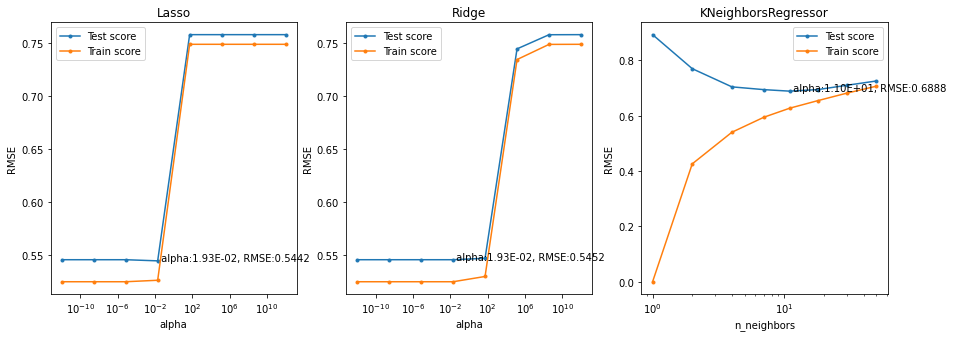

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
for grid_search, param, ax in zip(grid_searches,['alpha','alpha','n_neighbors'],axes):
    plot_tuning(grid_search, param, ax)

### Ejercicio 2.2
Interpreta los gráficos. ¿Cuándo se ajustan mal los métodos? ¿Cuándo sobreajustan? ¿Hasta qué punto son sensibles al hiperparámetro de regularización?
* Se puede ver que el único modelo que contemla un sobre ajuste es el de KNN pues para valores pequños del número de vecinos el RMSE cambia mucho entre los conjuntos de entrenamiento y de validación
* Los modelos ridge y Lasso se comportan de una manera similar  pues a valores pequeños (Menores a 1) de alpha el mse es bajo y para valores grandes el mse aumenta consideramblemente, por tanto para los modelos ridge y laso el RMSE es pequeño con un alpha de 0.0193 mientras que para knn el número de vecinos que minimiza el erroe es 11
* Los parámetros de regularización son sensibles en este caso pues se comportaan como una función sigmoidal la cual cambia mucho en un rango pequeño

### Ejercicio 2.3
ElasticNet permite mezclar pérdidas L1 y L2, y el hiperparámetro `l1_ratio` define el ratio de pérdidas L1. Por lo tanto, tiene dos hiperparámetros que interactúan: l1_ratio y alpha. Ejecute una búsqueda de cuadrícula (grid search) para obtener una matriz de valores l1_ratio y alpha y las puntuaciones de validación cruzada resultantes.

A continuación, utilice la función que se proporciona a continuación para trazar un mapa de calor de todos los valores e interpretar el resultado. ¿Puede explicar cómo interactúan los dos hiperparámetros?

In [80]:
from sklearn.model_selection import GridSearchCV
ElasticNet()

parameters = {"alpha":  np.logspace(0.0001, 100, num=10),
                      "l1_ratio": np.arange(0.0, 1.0, 0.1)}
model = ElasticNet()
grid_search_elastic= GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=10)
grid_search_elastic.fit(X, y)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.602e+01, tolerance: 2.401e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.931e+01, tolerance: 2.560e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

GridSearchCV(cv=10, estimator=ElasticNet(),
             param_grid={'alpha': array([1.00023029e+000, 1.29181404e+011, 1.66839930e+022, 2.15476543e+033,
       2.78291537e+044, 3.59418146e+055, 4.64194510e+066, 5.99514926e+077,
       7.74283492e+088, 1.00000000e+100]),
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
             scoring='neg_mean_squared_error')

In [82]:
results = grid_search_elastic.cv_results_['mean_test_score']

In [83]:
results = results.reshape((10, 10))

In [84]:
# Generic heatmap
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f", printvalues=False):
    """
    Plots a heatmap for the performance of a model for every combination of two hyperparameter values
    
    values: nxn array with all evaluation results, varying the first hyperparameter first
    xlabel: name of the first hyperparameter
    ylabel: name of the second hyperparameter
    xticklabels: values of the first hyperparameter
    yticklabels: values of the second hyperparameter
    cmap: colormap
    vmin: minimal score
    vmax: maximal score
    ax: plot axes
    fmt: format for printing the scores
    printvalues: whether to print the scores
    """
    if ax is None:
        ax = plt.gca()
    img = ax.pcolor(values, cmap=cmap, vmin=None, vmax=None)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel(ylabel, fontsize=10)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)
    
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12, labelrotation=90)

    if(printvalues):
        for p, color, value in zip(img.get_paths(), img.get_facecolors(), img.get_array()):
            x, y = p.vertices[:-2, :].mean(0)
            if np.mean(color[:3]) > 0.5:
                c = 'k'
            else:
                c = 'w'
            ax.text(x, y, fmt % value, color=c, ha="center", va="center", size=10)
    return img

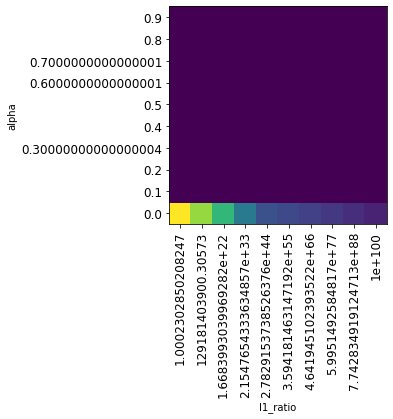

In [85]:
heatmap(results, "l1_ratio", "alpha", np.logspace(0.0001, 100, num=10), np.arange(0.0, 1.0, 0.1), cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f", printvalues=False)

Se puede ver que cuando alpha es 0 hay una variación de los resultados cuaando l1_ratio cambia, de lo contrario los resultados  se mantienen constantes

## Ejercicio 3: Visualización de los coeficientes
Por último, verifiquemos si los diferentes modelos lineales optimizados también encuentran los mismos coeficientes. 

### Ejercicio 3.1
Dibuje un [diagrama de dispersión](https://matplotlib.org/gallery/shapes_and_collections/scatter.html) con los coeficientes de los diferentes modelos en diferentes colores. ¿Ves mucha diferencia entre los distintos modelos?

Para todos los modelos, elija un parámetro alfa que parezca funcionar bien en el ejercicio anterior. En caso de duda, utilice alfa=0,001.

In [51]:
# Lasso
clf_lasso = Lasso(alpha=0.0193)
clf_lasso.fit(X,y)
# Ridge
clf_ridge = Ridge(alpha=0.0193)
clf_ridge.fit(X,y)

KNeighborsRegressor(n_neighbors=11)

Se hace el plor de un grñafico de barras para ver claramente como varían os coeficientes ajustados parz cada modelo y no hay mayor variación pues se obtienen valires similares para cada variable

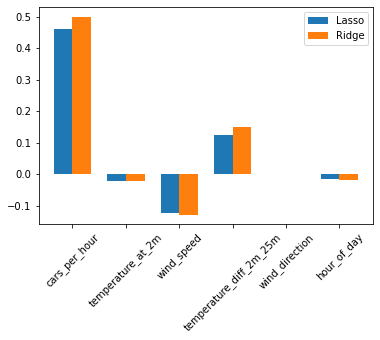

In [46]:
clf_lasso_coef = clf_lasso.coef_
clf_ridge_coef = clf_ridge.coef_

# Example column names
column_names = df.columns[:-1]

# Plot the barplot
fig, ax = plt.subplots()
x = np.arange(len(column_names))
width = 0.35
rects1 = ax.bar(x - width/2, clf_lasso_coef, width, label='Lasso')
rects2 = ax.bar(x + width/2, clf_ridge_coef, width, label='Ridge')
ax.set_xticks(x)
ax.set_xticklabels(column_names, rotation=45)
ax.legend()
plt.show()

### Ejercicio 3.2
Vuelve a dibujar el mismo gráfico pero ahora utilizando una gran cantidad de regularización (por ejemplo, alfa=1). ¿Qué observa? ¿Le ayuda esto a explicar la diferencia de rendimiento entre Ridge y Lasso en el ejercicio 1.2?

In [47]:
# Lasso
clf_lasso = Lasso(alpha=1)
clf_lasso.fit(X,y)
# Ridge
clf_ridge = Ridge(alpha=1)
clf_ridge.fit(X,y)

Ridge(alpha=1)

Se puyede ver que para un alpha de 1 cambiua totalmente la equivalencia de los modelos pues  Lasso elimina variables estimando los coeficientes como 0 (Solo 2 coeficientes son diferentes de 0). Por tanto la diferencia en el ejercicio 1.2 se explica claramente, pues lasso tiene un RMSE mayor con los parámetros por defecto

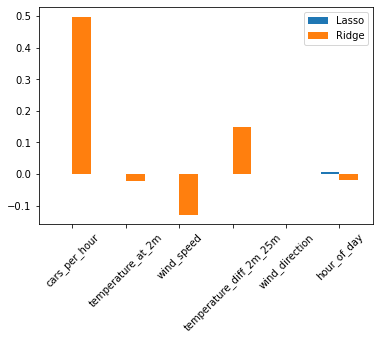

In [48]:
clf_lasso_coef = clf_lasso.coef_
clf_ridge_coef = clf_ridge.coef_

# Example column names
column_names = df.columns[:-1]

# Plot the barplot
fig, ax = plt.subplots()
x = np.arange(len(column_names))
width = 0.35
rects1 = ax.bar(x - width/2, clf_lasso_coef, width, label='Lasso')
rects2 = ax.bar(x + width/2, clf_ridge_coef, width, label='Ridge')
ax.set_xticks(x)
ax.set_xticklabels(column_names, rotation=45)
ax.legend()
plt.show()

In [65]:
clf_lasso_coef

array([ 0.        , -0.        , -0.        ,  0.        ,  0.00082737,
        0.00493506])